# CoinGecko API

In [1]:
import requests
import json
import datetime as dt
import time
from dateutil.relativedelta import relativedelta
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class CoinGeckoAPI():

  def __init__(self, base_url = 'https://api.coingecko.com/api/v3', vs_currency='usd'):
    self.base_url = base_url
    self.vs_currency = vs_currency

  def get_all_coins(self) -> pd.DataFrame:
    response = requests.get(f'{self.base_url}/coins/list').json()
    return pd.DataFrame.from_records(response)

  def get_all_categories(self) -> pd.DataFrame:
    response = requests.get(f'{self.base_url}/coins/categories/list').json()
    return pd.DataFrame.from_records(response)

  def get_coins_from_category(self, category_id) -> pd.DataFrame:
    response = requests.get(f'{self.base_url}/coins/markets?vs_currency={self.vs_currency}&category={category_id}').json()
    return pd.DataFrame.from_records(response)

  def get_historical_data(self, coin_id, begin: dt.datetime, end: dt.datetime) -> pd.DataFrame:
    begin_ts = time.mktime(begin.timetuple())
    end_ts = time.mktime(end.timetuple())
    response = requests.get(f'{self.base_url}/coins/{coin_id}/market_chart/range?vs_currency={self.vs_currency}&from={begin_ts}&to={end_ts}').json()
    return pd.DataFrame.from_records(response)

cg_api = CoinGeckoAPI()

In [3]:
cg_api.get_historical_data('genesis-mana', dt.datetime.now() - relativedelta(months=2), dt.datetime.now())

market_caps                               prices  \
0     [1644858774269, 0.0]   [1644858774269, 530.4091626697318]   
1     [1644862370367, 0.0]   [1644862370367, 526.9211796164628]   
2     [1644873171239, 0.0]   [1644873171239, 519.5420349977431]   
3     [1644876766226, 0.0]   [1644876766226, 522.3898466242575]   
4     [1644880376993, 0.0]   [1644880376993, 580.7390684700848]   
...                    ...                                  ...   
1291  [1649924096466, 0.0]  [1649924096466, 483.87887469395497]   
1292  [1649927781135, 0.0]   [1649927781135, 483.7540359291581]   
1293  [1649931322178, 0.0]  [1649931322178, 482.17315398044707]   
1294  [1649949348044, 0.0]  [1649949348044, 466.67152208789855]   
1295  [1649952919281, 0.0]   [1649952919281, 463.0924239639179]   

                            total_volumes  
0      [1644858774269, 5484.944776093221]  
1      [1644862370367, 5448.875651022239]  
2     [1644873171239, 1774.0418687120912]  
3     [1644876766226, 1783.7660810362456]  
4      [1644880376993, 5990.164144505268]  
...                                   ...  
1291   [1649924096466, 4646.451821738319]  
1292  [1649927781135, 4645.2530562280845]  
1293   [1649931322178, 4630.072621216973]  
1294   [1649949348044, 4925.555565589695]  
1295   [1649952919281, 3784.932391073039]  

[1296 rows x 3 columns]

In [4]:
from json import JSONDecodeError

categories = cg_api.get_all_categories()
n_coins_in_cat=[]
for cat in categories.category_id:
  try:
    n_coins_in_cat.append(cg_api.get_coins_from_category(cat).id.count())
  except JSONDecodeError:
    n_coins_in_cat.append(np.nan)

categories['coins'] = n_coins_in_cat
no_nan_categories = categories.dropna()
no_nan_categories

category_id                     name  coins
0               aave-tokens              Aave Tokens   69.0
1                 analytics                Analytics   16.0
2        arbitrum-ecosystem       Arbitrum Ecosystem   78.0
3   artificial-intelligence  Artificial Intelligence   29.0
4       asset-backed-tokens      Asset-backed Tokens  119.0
..                      ...                      ...    ...
82      moonriver-ecosystem      Moonriver Ecosystem   47.0
83             move-to-earn             Move To Earn   10.0
84                    music                    Music   14.0
85  near-protocol-ecosystem  Near Protocol Ecosystem   51.0
86                nft-index                NFT Index    5.0

[87 rows x 3 columns]

In [5]:
filtered_categories = no_nan_categories[no_nan_categories['coins'] > 10].sort_values(by='coins')
filtered_categories

category_id                          name   coins
53           guild-scholarship         Guild and Scholarship    11.0
33            elrond-ecosystem              Elrond Ecosystem    11.0
32                   education                     Education    11.0
84                       music                         Music    14.0
70             leveraged-token               Leveraged Token    14.0
..                         ...                           ...     ...
42            fantom-ecosystem              Fantom Ecosystem   276.0
24              cryptocurrency                Cryptocurrency   362.0
8          avalanche-ecosystem           Avalanche Ecosystem   385.0
28  decentralized-finance-defi  Decentralized Finance (DeFi)   422.0
12         binance-smart-chain           BNB Chain Ecosystem  3017.0

[62 rows x 3 columns]

In [7]:
# category = cg_api.get_coins_from_category('education')

# category_symbols = category[~category.market_cap_rank.isna()].symbol
# category_symbols

# YFinance

Pairs found:
* CELO x UBE
* CRO x MANA
* UNFI x BEL
* TIDAL x KYL
* ADA x ERG
* VIB x ASTRO
* MTSLA x MMSFT

In [8]:
import pandas_datareader as web
from pandas_datareader._utils import RemoteDataError
import yfinance

In [9]:
def get_crypto_info(crypto_name, start_date=dt.datetime.now() - relativedelta(days=59), end_date=dt.datetime.now()):
  # try:
  #   return web.DataReader(f"{crypto_name.upper()}-USD", "yahoo", start_date, end_date)
  # except RemoteDataError or KeyError:
  #   return None
  start = start_date.date().isoformat()
  end = end_date.date().isoformat()
  return yfinance.download(tickers=f'{crypto_name.upper()}-USD', start=start, end=end, interval='1h')


pairs = np.array([
          ['CELO', 'UBE'],
          ['CRO', 'MANA'],
          ['TIDAL', 'KYL'],
          ['ADA', 'ERG'],
          ['VIB', 'ASTRO'],
          ['MTSLA', 'MMSFT'],
        ])

known_coins = ['ETH', 'BTC', 'AAVE', 'SHIB', 'XLM', 'ADA', 'CRV', 'MANA', 'ALGO', 'CRO', 'BSW', 'LUNA', 'XRP', 'LINK']

coins = np.unique(np.append(pairs.reshape(pairs.shape[0]*pairs.shape[1]), known_coins))

# coins = category_symbols

dfs = [
  get_crypto_info(coin)[['Open']].rename(columns={'Open':coin.upper()})
  # get_crypto_info(coin).drop(columns=['Adj Close'])
  for coin in coins
  if get_crypto_info(coin) is not None
]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [10]:
concat_df = pd.concat(dfs,axis=1)
concat_df

AAVE       ADA      ALGO     ASTRO       BSW  \
2022-02-14 03:00:00+00:00  154.865845  1.023614  0.877868  0.136270  0.506858   
2022-02-14 04:00:00+00:00  155.952011  1.032577  0.884699  0.136725  0.506563   
2022-02-14 05:00:00+00:00  156.121796  1.032881  0.886187  0.136606  0.506994   
2022-02-14 06:00:00+00:00  154.387115  1.027508  0.877571  0.136436  0.506226   
2022-02-14 07:00:00+00:00  156.034790  1.033347  0.885994  0.136944  0.504978   
...                               ...       ...       ...       ...       ...   
2022-04-13 23:00:00+00:00  176.307297  0.973166  0.743532  0.139706  1.150861   
2022-04-14 00:00:00+00:00  178.346451  0.974569  0.745255  0.139617  1.242826   
2022-04-14 01:00:00+00:00  178.181625  0.973828  0.747905  0.139672  1.242350   
2022-04-14 02:00:00+00:00  179.548477  0.983548  0.755737  0.140343  1.233037   
2022-04-14 03:00:00+00:00  178.465240  0.978844  0.755019       NaN       NaN   

                                    BTC      CELO       CRO       CRV  \
2022-02-14 03:00:00+00:00  41740.113281  2.847101  0.479630  2.686385   
2022-02-14 04:00:00+00:00  41927.359375  2.872855  0.479813  2.731914   
2022-02-14 05:00:00+00:00  41969.816406  2.861313  0.482375  2.731687   
2022-02-14 06:00:00+00:00  41818.652344  2.846604  0.478062  2.715034   
2022-02-14 07:00:00+00:00  42179.953125  2.869296  0.480559  2.747864   
...                                 ...       ...       ...       ...   
2022-04-13 23:00:00+00:00  41249.832031  3.269110  0.422231  2.296386   
2022-04-14 00:00:00+00:00  41160.218750  3.264895  0.422625  2.293959   
2022-04-14 01:00:00+00:00  41207.503906  3.328640  0.422639  2.306597   
2022-04-14 02:00:00+00:00  41446.488281  3.356542  0.425510  2.322563   
2022-04-14 03:00:00+00:00  41403.046875  3.325446  0.425738  2.308577   

                                ERG  ...      LUNA      MANA       MMSFT  \
2022-02-14 03:00:00+00:00  3.204723  ...  0.007931  2.736657  303.983124   
2022-02-14 04:00:00+00:00  3.223276  ...  0.007966  2.757014  304.056854   
2022-02-14 05:00:00+00:00  3.200710  ...  0.007974  2.764909  303.992493   
2022-02-14 06:00:00+00:00  3.215727  ...  0.007946  2.730529  304.022766   
2022-02-14 07:00:00+00:00  3.208610  ...  0.008014  2.771878  304.677032   
...                             ...  ...       ...       ...         ...   
2022-04-13 23:00:00+00:00  4.302454  ...  0.004953  2.193207  331.686127   
2022-04-14 00:00:00+00:00  4.311239  ...  0.004939  2.200854  331.694916   
2022-04-14 01:00:00+00:00  4.319329  ...  0.004944  2.204968  331.700989   
2022-04-14 02:00:00+00:00  4.387054  ...  0.004974  2.235085  331.712921   
2022-04-14 03:00:00+00:00  4.353297  ...       NaN  2.221425         NaN   

                                 MTSLA      SHIB     TIDAL       UBE  \
2022-02-14 03:00:00+00:00   936.055420  0.000029  0.001491  0.162958   
2022-02-14 04:00:00+00:00   936.282410  0.000029  0.001474  0.163870   
2022-02-14 05:00:00+00:00   936.084229  0.000029  0.001478  0.163249   
2022-02-14 06:00:00+00:00   936.182129  0.000029  0.001491  0.162387   
2022-02-14 07:00:00+00:00   938.196838  0.000029  0.001485  0.164017   
...                                ...       ...       ...       ...   
2022-04-13 23:00:00+00:00  1173.823853  0.000027  0.000783  0.246611   
2022-04-14 00:00:00+00:00  1173.854980  0.000027  0.000792  0.246131   
2022-04-14 01:00:00+00:00  1173.876465  0.000027  0.000788  0.251620   
2022-04-14 02:00:00+00:00  1173.918701  0.000027  0.000789  0.263881   
2022-04-14 03:00:00+00:00          NaN  0.000027       NaN       NaN   

                                VIB       XLM       XRP  
2022-02-14 03:00:00+00:00  0.034246  0.206598  0.787995  
2022-02-14 04:00:00+00:00  0.034577  0.207536  0.792977  
2022-02-14 05:00:00+00:00  0.034861  0.208375  0.793980  
2022-02-14 06:00:00+00:00  0.034230  0.207797  0.787795  
2022-02-14 07:00:00+00:00  0.034822  0.209538  0.795327  
...                             ...       ...       ...  

In [11]:
from sklearn import preprocessing

def normalize(df: pd.DataFrame, method:str='std'):
  if method == 'min_max':
    scaler = preprocessing.MinMaxScaler()
    return pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index), scaler
  if method == 'pct_cumsum':
    return df.pct_change().cumsum().dropna(), None
  if method == 'pct':
    return df.pct_change().dropna(), None
  if method == 'std':
    scaler = preprocessing.StandardScaler()
    return pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index), scaler
  if method == 'None':
    return df, None

In [12]:
days =0
normalized_df, scaler = normalize(concat_df[-days:], method='None')

In [13]:
px.line(normalized_df)

<AxesSubplot:>

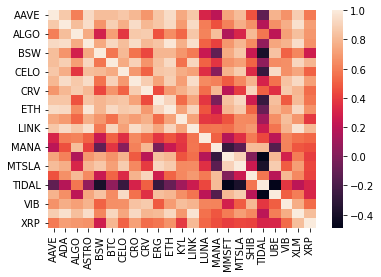

In [14]:
import seaborn as sns

sns.heatmap(normalized_df.dropna().corr(), )

In [15]:
normalized_df.dropna().corr()

AAVE       ADA      ALGO     ASTRO       BSW       BTC      CELO  \
AAVE   1.000000  0.864733  0.603286  0.927132  0.820905  0.823966  0.856170   
ADA    0.864733  1.000000  0.825146  0.947265  0.669893  0.884277  0.763849   
ALGO   0.603286  0.825146  1.000000  0.752264  0.285517  0.707551  0.373773   
ASTRO  0.927132  0.947265  0.752264  1.000000  0.748839  0.919493  0.822884   
BSW    0.820905  0.669893  0.285517  0.748839  1.000000  0.574028  0.804532   
BTC    0.823966  0.884277  0.707551  0.919493  0.574028  1.000000  0.753579   
CELO   0.856170  0.763849  0.373773  0.822884  0.804532  0.753579  1.000000   
CRO    0.797361  0.938858  0.865516  0.939325  0.563482  0.898972  0.686054   
CRV    0.678204  0.797513  0.877147  0.804920  0.427583  0.672737  0.507750   
ERG    0.852900  0.850495  0.461500  0.843067  0.793715  0.834122  0.849424   
ETH    0.939076  0.924433  0.649319  0.979294  0.793913  0.926334  0.866447   
KYL    0.748715  0.694508  0.526168  0.772950  0.680050  0.553476  0.756848   
LINK   0.859088  0.933942  0.856554  0.947924  0.586305  0.916199  0.719260   
LUNA   0.303909  0.596105  0.612416  0.508749  0.248202  0.510529  0.345580   
MANA   0.202450  0.457525  0.824966  0.408646 -0.114108  0.367340  0.017206   
MMSFT  0.727727  0.610111  0.157925  0.683897  0.753659  0.667914  0.781397   
MTSLA  0.814200  0.762969  0.311206  0.791025  0.858506  0.710106  0.875620   
SHIB   0.462826  0.659620  0.802382  0.639108  0.246909  0.515171  0.326215   
TIDAL -0.120351  0.177612  0.575204  0.053806 -0.386803  0.051901 -0.268643   
UBE    0.784470  0.653722  0.208029  0.733753  0.841221  0.640976  0.930411   
VIB    0.667799  0.764087  0.714901  0.784117  0.507878  0.655429  0.660387   
XLM    0.882011  0.956990  0.827554  0.941896  0.623049  0.913068  0.737718   
XRP    0.582198  0.707412  0.683031  0.664255  0.267395  0.792232  0.507941   

            CRO       CRV       ERG  ...      LUNA      MANA     MMSFT  \
AAVE   0.797361  0.678204  0.852900  ...  0.303909  0.202450  0.727727   
ADA    0.938858  0.797513  0.850495  ...  0.596105  0.457525  0.610111   
ALGO   0.865516  0.877147  0.461500  ...  0.612416  0.824966  0.157925   
ASTRO  0.939325  0.804920  0.843067  ...  0.508749  0.408646  0.683897   
BSW    0.563482  0.427583  0.793715  ...  0.248202 -0.114108  0.753659   
BTC    0.898972  0.672737  0.834122  ...  0.510529  0.367340  0.667914   
CELO   0.686054  0.507750  0.849424  ...  0.345580  0.017206  0.781397   
CRO    1.000000  0.879061  0.726096  ...  0.634609  0.604889  0.487659   
CRV    0.879061  1.000000  0.439906  ...  0.544773  0.797850  0.191971   
ERG    0.726096  0.439906  1.000000  ...  0.374484 -0.027251  0.837061   
ETH    0.884505  0.687845  0.911476  ...  0.466137  0.248579  0.791690   
KYL    0.706174  0.768126  0.538353  ...  0.383106  0.365185  0.466153   
LINK   0.946749  0.855638  0.736674  ...  0.566070  0.574428  0.547221   
LUNA   0.634609  0.544773  0.374484  ...  1.000000  0.503954  0.175357   
MANA   0.604889  0.797850 -0.027251  ...  0.503954  1.000000 -0.278820   
MMSFT  0.487659  0.191971  0.837061  ...  0.175357 -0.278820  1.000000   
MTSLA  0.631867  0.394762  0.918719  ...  0.353183 -0.139829  0.898395   
SHIB   0.783234  0.911746  0.268674  ...  0.583485  0.816742  0.005099   
TIDAL  0.296692  0.502835 -0.271376  ...  0.424219  0.812255 -0.488970   
UBE    0.554660  0.352549  0.830690  ...  0.202806 -0.168234  0.804558   
VIB    0.839361  0.870846  0.487762  ...  0.618043  0.611571  0.290370   
XLM    0.929912  0.792686  0.808362  ...  0.557659  0.473959  0.588991   
XRP    0.713635  0.546238  0.571700  ...  0.528000  0.451837  0.397959   

          MTSLA      SHIB     TIDAL       UBE       VIB       XLM       XRP  
AAVE   0.814200  0.462826 -0.120351  0.784470  0.667799  0.882011  0.582198  
ADA    0.762969  0.659620  0.177612  0.653722  0.764087  0.956990  0.707412  
ALGO   0.311206  0.802382  0.575204  0.208029  0.714901  0.827554  0.683031  
ASTRO  0.791025  0.639108

In [16]:
normalized_df.dropna().corr()[normalized_df.dropna().corr()>0.9]

AAVE       ADA  ALGO     ASTRO  BSW       BTC      CELO       CRO  \
AAVE   1.000000       NaN   NaN  0.927132  NaN       NaN       NaN       NaN   
ADA         NaN  1.000000   NaN  0.947265  NaN       NaN       NaN  0.938858   
ALGO        NaN       NaN   1.0       NaN  NaN       NaN       NaN       NaN   
ASTRO  0.927132  0.947265   NaN  1.000000  NaN  0.919493       NaN  0.939325   
BSW         NaN       NaN   NaN       NaN  1.0       NaN       NaN       NaN   
BTC         NaN       NaN   NaN  0.919493  NaN  1.000000       NaN       NaN   
CELO        NaN       NaN   NaN       NaN  NaN       NaN  1.000000       NaN   
CRO         NaN  0.938858   NaN  0.939325  NaN       NaN       NaN  1.000000   
CRV         NaN       NaN   NaN       NaN  NaN       NaN       NaN       NaN   
ERG         NaN       NaN   NaN       NaN  NaN       NaN       NaN       NaN   
ETH    0.939076  0.924433   NaN  0.979294  NaN  0.926334       NaN       NaN   
KYL         NaN       NaN   NaN       NaN  NaN       NaN       NaN       NaN   
LINK        NaN  0.933942   NaN  0.947924  NaN  0.916199       NaN  0.946749   
LUNA        NaN       NaN   NaN       NaN  NaN       NaN       NaN       NaN   
MANA        NaN       NaN   NaN       NaN  NaN       NaN       NaN       NaN   
MMSFT       NaN       NaN   NaN       NaN  NaN       NaN       NaN       NaN   
MTSLA       NaN       NaN   NaN       NaN  NaN       NaN       NaN       NaN   
SHIB        NaN       NaN   NaN       NaN  NaN       NaN       NaN       NaN   
TIDAL       NaN       NaN   NaN       NaN  NaN       NaN       NaN       NaN   
UBE         NaN       NaN   NaN       NaN  NaN       NaN  0.930411       NaN   
VIB         NaN       NaN   NaN       NaN  NaN       NaN       NaN       NaN   
XLM         NaN  0.956990   NaN  0.941896  NaN  0.913068       NaN  0.929912   
XRP         NaN       NaN   NaN       NaN  NaN       NaN       NaN       NaN   

            CRV       ERG  ...  LUNA  MANA  MMSFT     MTSLA      SHIB  TIDAL  \
AAVE        NaN       NaN  ...   NaN   NaN    NaN       NaN       NaN    NaN   
ADA         NaN       NaN  ...   NaN   NaN    NaN       NaN       NaN    NaN   
ALGO        NaN       NaN  ...   NaN   NaN    NaN       NaN       NaN    NaN   
ASTRO       NaN       NaN  ...   NaN   NaN    NaN       NaN       NaN    NaN   
BSW         NaN       NaN  ...   NaN   NaN    NaN       NaN       NaN    NaN   
BTC         NaN       NaN  ...   NaN   NaN    NaN       NaN       NaN    NaN   
CELO        NaN       NaN  ...   NaN   NaN    NaN       NaN       NaN    NaN   
CRO         NaN       NaN  ...   NaN   NaN    NaN       NaN       NaN    NaN   
CRV    1.000000       NaN  ...   NaN   NaN    NaN       NaN  0.911746    NaN   
ERG         NaN  1.000000  ...   NaN   NaN    NaN  0.918719       NaN    NaN   
ETH         NaN  0.911476  ...   NaN   NaN    NaN       NaN       NaN    NaN   
KYL         NaN       NaN  ...   NaN   NaN    NaN       NaN       NaN    NaN   
LINK        NaN       NaN  ...   NaN   NaN    NaN       NaN       NaN    NaN   
LUNA        NaN       NaN  ...   1.0   NaN    NaN       NaN       NaN    NaN   
MANA        NaN       NaN  ...   NaN   1.0    NaN       NaN       NaN    NaN   
MMSFT       NaN       NaN  ...   NaN   NaN    1.0       NaN       NaN    NaN   
MTSLA       NaN  0.918719  ...   NaN   NaN    NaN  1.000000       NaN    NaN   
SHIB   0.911746       NaN  ...   NaN   NaN    NaN       NaN  1.000000    NaN   
TIDAL       NaN       NaN  ...   NaN   NaN    NaN       NaN       NaN    1.0   
UBE         NaN       NaN  ...   NaN   NaN    NaN       NaN       NaN    NaN   
VIB         NaN       NaN  ...   NaN   NaN    NaN       NaN       NaN    NaN   
XLM         NaN       NaN  ...   NaN   NaN    NaN       NaN       NaN    NaN   
XRP         NaN       NaN  ...   NaN   NaN    NaN       NaN       NaN    NaN   

            UBE  VIB       XLM  XRP  
AAVE        NaN  NaN       NaN  NaN  
ADA         NaN  NaN  0.956990  NaN  
ALGO        NaN  NaN       NaN  NaN  
ASTRO       NaN  

In [17]:
from statsmodels.tsa.stattools import coint

all_combinations = [[coins[i], coins[j]] for i in range(len(coins)) for j in range(len(coins)) if i != j and j > i]

p_values = {}
for combination in all_combinations:
  p_values['-'.join(combination)] = coint(normalized_df.dropna()[combination[0]], normalized_df.dropna()[combination[1]])[1]

In [18]:
cointegrations = list(filter(lambda x: x[1] <= 0.05, p_values.items()))

new_pairs = [pair[0].split('-') for pair in cointegrations]

new_coins = np.unique(np.array(new_pairs).flatten())

cointegrations

[('ADA-CRO', 0.013863812996408693),
 ('ASTRO-CRO', 0.005972771690337291),
 ('BSW-CELO', 0.02914917522807369),
 ('BSW-MTSLA', 0.024588868807379507),
 ('BSW-UBE', 0.0017496770073462133),
 ('CELO-MTSLA', 0.02583495999195859),
 ('CELO-UBE', 0.01853922651326167),
 ('CRO-LINK', 0.01594872919241662),
 ('CRO-XLM', 0.009968351524351318),
 ('CRV-SHIB', 0.02990057300928553),
 ('CRV-VIB', 0.017714414469910185),
 ('KYL-VIB', 0.04729935149398233),
 ('LINK-XLM', 0.011232533515063014),
 ('LUNA-SHIB', 0.04902174286008972),
 ('LUNA-VIB', 0.020809534656217803),
 ('LUNA-XLM', 0.04398535929034011),
 ('LUNA-XRP', 0.03425001761801537),
 ('MANA-TIDAL', 0.008704445972528198),
 ('MTSLA-UBE', 0.030962995347478484),
 ('SHIB-VIB', 0.008500011190362148),
 ('VIB-XLM', 0.038097843439890394)]

In [19]:
cropped_df = normalized_df[new_coins].dropna()
len(cropped_df)

1415

# TSA

In [20]:
px.line(cropped_df, x=cropped_df.index, y=cropped_df.columns, title='Crypto Analysis')

In [21]:
extended_df = cropped_df.copy()

In [22]:
pairs = new_pairs
coins = new_coins

In [23]:
extended_df['Ratio'] = extended_df[pairs[0][0]]/extended_df[pairs[0][1]]
window = 50
extended_df['MA_Ratio'] = extended_df['Ratio'].rolling(window=window).mean()


px.line(extended_df[['Ratio', 'MA_Ratio']].dropna())

In [24]:
norm_ratio, _ = normalize(extended_df[['Ratio']], 'std')
px.line(norm_ratio)

### Backtesting

In [35]:
div_threshold = float(1) # std threshold as to when the ratio diverges
conv_threshold = float(0.2) # std threshold as to when the ratio converges
init_threshold = float(0.1) # make initial bet to buy some stock
mean_average_q = 10
window = 24*10

print('Diversion threshold is', div_threshold)
print('Conversion threshold is', conv_threshold)
print('Initial threshold is', init_threshold)
print('Window size is', window)

Diversion threshold is 1.0
Conversion threshold is 0.2
Initial threshold is 0.1
Window size is 240


In [36]:
def buy_stock(stock:str, cash:float, price:float):
  amount = cash/price
  if cash > wallet['available_cash']:
    if abs(cash-wallet['available_cash']) < 0.0001:
      cash = wallet['available_cash']
    else:
      raise Exception(f"ERROR: No cash available. Available:{wallet['available_cash']}, Value:{cash}") 
  wallet['available_cash'] -= cash
  wallet['coins'][stock]['amount'] += amount
  wallet['coins'][stock]['cash'] += cash

def sell_stock(stock:str, amount:float, price:float):
  total_value = amount*price
  if amount > wallet['coins'][stock]['amount']:
    raise Exception('ERROR: Selling limit exceeded.')
  wallet['available_cash'] += total_value
  wallet['coins'][stock]['amount'] -= amount
  wallet['coins'][stock]['cash'] = price*wallet['coins'][stock]['amount']

def update_values(wallet, prices):
  total = wallet['available_cash'] if 'available_cash' in wallet else 0
  for coin in wallet['coins']:
    updated_value = wallet['coins'][coin]['amount']*prices[coin]
    wallet['coins'][coin]['cash'] = updated_value
    total+=updated_value
  wallet['total'] = round(total,4)


In [41]:
from pprint import pprint

total_cash = []
inflexion_points = []

init_cash = 1000

wallet = {
  'available_cash': init_cash,
  'coins': {
    coin: {
      'amount':0,
      'cash':0
    }
    for coin in coins
  }
}

control_group = {
  'total':init_cash,
  'coins':{}
}


iterate_df = cropped_df.copy()

for i, (date, prices) in enumerate(iterate_df[window:].iterrows()):

  if i==0:
    for coin in coins:
      control_group['coins'][coin] = {
        'amount': init_cash/len(coins)/prices[coin],
        'cash': init_cash/len(coins)
      }

  train_df = pd.concat([
    iterate_df[i:window+i],
    pd.DataFrame(prices).T
  ])

  last_ratios = []

  update_values(wallet, prices)
  update_values(control_group, prices)
  
  for j, pair in enumerate(pairs):

    train_df[f'ratio_{j}'] = train_df[pair[0]]/train_df[pair[1]]
    norm_ratio, scaler = normalize(train_df[[f'ratio_{j}']])
    last_ratios.append(norm_ratio[f'ratio_{j}'][-1])
  
  if not all(wallet['coins'][coin]['amount'] for coin in coins): #no money allocated
    coins_inside_init_th = list(map(lambda x: abs(x)<= init_threshold,last_ratios))
    if any(coins_inside_init_th): #if any coin is inside the init_threshold
      split = wallet['available_cash']/(2*sum(coins_inside_init_th))
      for k in range(sum(coins_inside_init_th)):
        buy_stock(pairs[k][0], split, prices[pairs[k][0]])
        buy_stock(pairs[k][1], split, prices[pairs[k][1]])
      inflexion_points.append(date)

  ratios_over_threshold = list(map(lambda x: abs(x) > div_threshold, last_ratios))
  ratios_in_conv_threshold = list(map(lambda x: abs(x) < conv_threshold, last_ratios))

  if any(ratios_in_conv_threshold):
    for j, in_th in enumerate(ratios_in_conv_threshold):
      if in_th:
        # sell stock 0
        sell_amount = wallet['coins'][pairs[j][0]]['amount']
        sell_stock(pairs[j][0], sell_amount, prices[pairs[j][0]])
        # sell stock 1
        sell_amount = wallet['coins'][pairs[j][1]]['amount']
        sell_stock(pairs[j][1], sell_amount, prices[pairs[j][1]])

  if any(ratios_over_threshold):
    for j, over_th in enumerate(ratios_over_threshold):
      if over_th:
        if last_ratios[j] > 0:
          # sell stock 0
          sell_amount = wallet['coins'][pairs[j][0]]['amount']
          sell_stock(pairs[j][0], sell_amount, prices[pairs[j][0]])

        else:
          # sell stock 1
          sell_amount = wallet['coins'][pairs[j][1]]['amount']
          sell_stock(pairs[j][1], sell_amount, prices[pairs[j][1]])

    over_list = list(filter(lambda x: abs(x) > div_threshold, last_ratios))

    weights = np.abs(over_list)/sum(np.abs(over_list))

    split = wallet['available_cash']*weights
    w_idx = 0
    for j, over_th in enumerate(ratios_over_threshold):
      if over_th:
        if last_ratios[j] > 0:
          # buy stock 1
          buy_stock(pairs[j][1],split[w_idx],prices[pairs[j][1]])
        else:
          # buy stock 0
          buy_stock(pairs[j][0],split[w_idx],prices[pairs[j][0]])
        w_idx+=1

    inflexion_points.append(date)

  total_cash_dict = {
    'wallet': wallet['total'],
    'control group': control_group['total'],
  }
  for coin in coins:
    total_cash_dict[coin] = wallet['coins'][coin]['cash']

  total_cash.append(total_cash_dict)

pprint(wallet)  

#   slope = 0

#   try:
#     slope = sum(np.diff([cash['total'] for cash in total_cash[-mean_average_q-1:-1]]))
#     if slope < 0:
#       if wallet[pair[0]]['amount']:
#         sell_stock(pair[0], wallet[pair[0]]['amount'], prices[pair[0]])
#       if wallet[pair[1]]['amount']:
#         sell_stock(pair[1], wallet[pair[1]]['amount'], prices[pair[1]])
#       continue
#   except IndexError:
#     pass

{'available_cash': 1.044048714879764e-52,
 'coins': {'ADA': {'amount': 1786.7182968686138, 'cash': 1757.3225426568806},
           'ASTRO': {'amount': 0.0, 'cash': 0.0},
           'BSW': {'amount': 0.0, 'cash': 0.0},
           'CELO': {'amount': 0.000668554047141076,
                    'cash': 0.0022440294935447812},
           'CRO': {'amount': 0.0, 'cash': 0.0},
           'CRV': {'amount': 0.000263412543174671,
                   'cash': 0.0006117922088563606},
           'KYL': {'amount': 0.0, 'cash': 0.0},
           'LINK': {'amount': 1.1992951007996149, 'cash': 17.15407651020521},
           'LUNA': {'amount': 4.391482848429533, 'cash': 0.02184401549632874},
           'MANA': {'amount': 0.0, 'cash': 0.0},
           'MTSLA': {'amount': 0.0, 'cash': 0.0},
           'SHIB': {'amount': 0.0, 'cash': 0.0},
           'TIDAL': {'amount': 368633.203734565, 'cash': 290.8304454599994},
           'UBE': {'amount': 0.0, 'cash': 0.0},
           'VIB': {'amount': 0.017752465070987378,

In [42]:
print('Number of operations:', len(inflexion_points))

Number of operations: 1983


In [43]:
cash_flow = pd.DataFrame.from_records(total_cash, index=iterate_df[window:].index)
px.line(
  cash_flow, title='Valor total por Data'
)

## VAR and ARIMA

In [124]:
train_df['Ratio'] = train_df[pair[0]]/train_df[pair[1]]
norm_ratio, scaler = normalize(train_df[['Ratio']])

In [131]:
res1 = adfuller(extended_df['Ratio'].dropna())
res2 = adfuller(extended_df['Spread'].dropna())

print(res1[1], res2[1])

0.015200585623939295 0.000754395032531842


In [107]:
p_values = {}
for ts in cropped_df:
  result = adfuller(cropped_df[ts])
  p_values[ts] = result[1]

df_1d = cropped_df.diff().dropna()
for ts in df_1d:
  result = adfuller(df_1d[ts])
  p_values[ts] = result[1]

p_values

{'CRO': 0.6973141402511988, 'MANA': 0.4865219568622367}

In [70]:
def inverse_difference(forecast_df: pd.DataFrame, train_df: pd.DataFrame, n_diffs: int):
  inversed_df = forecast_df.copy()
  
  for _ in range(n_diffs):
    for coin in train_df:
      inversed_df[f'PREDICTED_{coin}'] = train_df[coin].iloc[-1] +  inversed_df[f'PREDICTED_{coin}'].cumsum()
  
  return inversed_df

In [71]:
from statsmodels.tsa.vector_ar.var_model import VAR

n_predictions = 7

train_df = cropped_df[:-n_predictions]
test_df = cropped_df[-n_predictions:]

train_1d = train_df.diff().dropna()

forecasting_model = VAR(train_1d)

aics = [forecasting_model.fit(n).aic for n in range(1,n_predictions)]
best_order = np.argmin(aics) + 1

lagged_values = train_1d.values[-best_order:]

fitted_model = forecasting_model.fit(best_order)

forecast_cols = [f'PREDICTED_{coin}' for coin in test_df.columns]

forecast = pd.DataFrame(fitted_model.forecast(y=lagged_values, steps=n_predictions), index=test_df.index, columns=forecast_cols)

inversed_forecast = inverse_difference(forecast, train_df, 1)

evaluate = pd.concat([
  test_df,
  inversed_forecast,
], axis=1)

/home/eduardo/anaconda3/envs/time-series/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



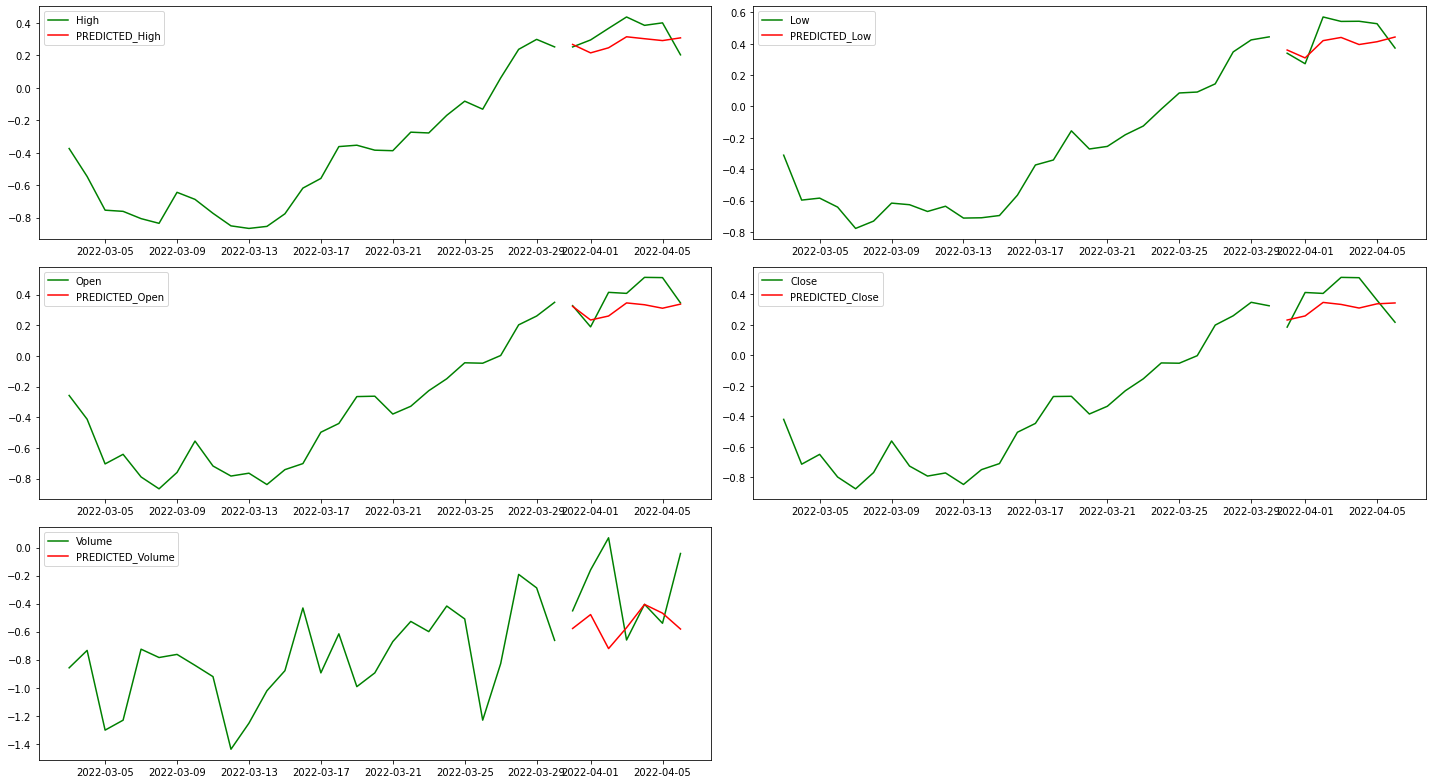

In [72]:
pairs = [(f'{coin}', f'PREDICTED_{coin}') for coin in train_df.columns]
plt.figure(figsize=(20,11))
for i,pair in enumerate(pairs, start=1):
  plt.subplot(3,2,i)
  plt.plot(train_df[pair[0]][-n_predictions*4:], color='green')
  plt.plot(evaluate[pair[0]], label=pair[0], color='green')
  plt.plot(evaluate[pair[1]], label=pair[1], color='red')
  plt.legend()
  plt.tight_layout()

In [155]:
from statsmodels.tsa.seasonal import seasonal_decompose

results = seasonal_decompose(extended_df.Ratio.dropna())
results.plot()

ValueError: You must specify a period or x must be a pandas object with a PeriodIndex or a DatetimeIndex with a freq not set to None

Text(0.5, 1.0, 'Spread')

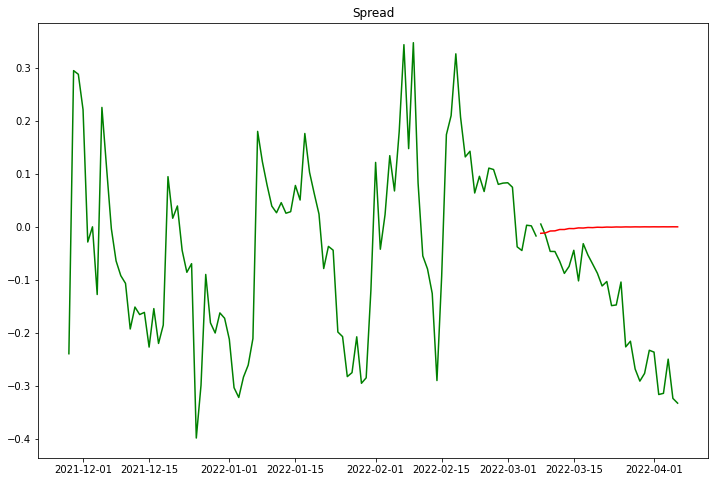

In [108]:
from pmdarima import auto_arima

n_predictions = 30

train_df = extended_df[:-n_predictions]
test_df = extended_df[-n_predictions:]

model = auto_arima(train_df['Spread'])

forecast, conf_int = model.predict(n_periods=n_predictions, return_conf_int=True)

plt.figure(figsize=(12,8))
plt.plot(train_df['Spread'][-100:], color='green')
plt.plot(test_df['Spread'], color='green')
plt.plot(test_df.index, forecast, color='red')
plt.title('Spread')

# LSTM

In [68]:
# univariate lstm example
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

# define input sequence

n_predictions = 30

train_df = cropped_df[pair[0]][:-n_predictions]
test_df = cropped_df[pair[0]][-n_predictions:]

raw_seq = train_df.values

# choose a number of time steps
n_steps = 30
# split into samples
X, y = split_sequence(raw_seq, n_steps)
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))


# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=200, verbose=0)

In [71]:
# demonstrate prediction

inputs = pd.concat([
  train_df[-n_steps:],
  test_df
])

predictions = []

for i in range(n_steps, len(inputs)):
  x_input = inputs[i-n_steps:i].values
  x_input = x_input.reshape((1, n_steps, n_features))
  yhat = model.predict(x_input, verbose=0)
  predictions.append(yhat[0][0])

evaluate = pd.concat([
  test_df,
  pd.Series(predictions, index=test_df.index, name=f'PRED_{pair[0]}')
], axis=1
)
evaluate.head()

CRO  PRED_CRO
Date                          
2022-03-10  0.408728  0.386783
2022-03-11  0.389377  0.398052
2022-03-12  0.382748  0.397838
2022-03-13  0.388292  0.395780
2022-03-14  0.376952  0.397596

In [72]:
px.line(evaluate, title='Predicted x Real')